In [ ]:
#import statements
import os
import math
import time
import copy
import random
import argparse
import itertools
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, SubsetRandomSampler, WeightedRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
print("Connecting to Google Drive...")

In [ ]:
# Define the paths for the new dataset in Google Drive
base_gdrive_path = '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset'
image_folder_gdrive = os.path.join(base_gdrive_path, 'ISIC_2019_Training_Input')
metadata_file_gdrive = os.path.join(base_gdrive_path, 'ISIC_2019_Training_GroundTruth.csv')


In [ ]:
#reproducability
def set_all_seeds(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Configuration via dataclass
@dataclass
class TrainConfig:
    csv_path: str
    images_dir: str
    out_dir: str = "artifacts"
    image_size: int = 224
    batch_size: int = 32
    num_workers: int = 0
    max_epochs: int = 20
    lr: float = 1e-3
    weight_decay: float = 1e-4
    use_sampler: bool = True
    sampler_epoch_fraction: float = 0.9
    model_name: str = "efficientnet_b2"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 1337
    checkpoint_name: str = "best_model.pth"

In [ ]:
#data prep
def split_dataframe(df: pd.DataFrame, train=0.7, val=0.15, seed=123) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    shuffled = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n = len(shuffled)
    a = int(train * n)
    b = a + int(val * n)
    return shuffled.iloc[:a], shuffled.iloc[a:b], shuffled.iloc[b:]


def describe_class_balance(df: pd.DataFrame) -> Dict[str, int]:
    print("DATASET OVERVIEW")
    counts = df["label"].value_counts().sort_index()
    print("\n[Class balance]")
    for c, k in counts.items():
        print(f"  - {c:<6} : {k:>5}")
    print(f"  Total: {len(df)}")
    print("analysis done")
    return counts.to_dict()

In [ ]:
# class dataset
class DermDataset(Dataset):
    """
    Lightweight dataset: expects a CSV with columns:
      - 'filename' (image stem or filename) and
      - one-hot columns (MEL, NV, BCC, AK, BKL, DF, VASC, SCC, UNK) or 'label' string.
    We map to indices internally for PyTorch.
    """
    def __init__(
        self,
        df: pd.DataFrame,
        root: str,
        tfm: Optional[transforms.Compose] = None,
        expected_ext: str = ".jpg",
    ):
        self.df = df.reset_index(drop=True).copy()
        self.root = root
        self.tfm = tfm
        self.expected_ext = expected_ext

        # If no 'label' column provided, infer from one-hot max
        if "label" not in self.df.columns:
            class_cols = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC", "UNK"]
            self.df["label"] = self.df[class_cols].idxmax(axis=1)

        # Make sure filenames end with .jpg (or chosen extension)
        self.df["filename"] = self.df["filename"].apply(
            lambda x: x if x.lower().endswith(self.expected_ext) else os.path.splitext(x)[0] + self.expected_ext
        )

        # Build mappings
        self.class_names = sorted(self.df["label"].unique().tolist())
        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}

        self.df["y"] = self.df["label"].map(self.class_to_idx).astype(int)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, int]:
        row = self.df.iloc[i]
        img_path = os.path.join(self.root, row["filename"])

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            # fallback: black tile if file is missing/broken
            img = Image.new("RGB", (224, 224), "black")

        # We'll assume images are already the desired size; else, add Resize here
        if self.tfm is not None:
            img = self.tfm(img)

        return img, int(row["y"])

In [ ]:
#transforms + data augemntation
def build_transforms(image_size: int) -> Tuple[transforms.Compose, transforms.Compose]:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_tfms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.25),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        normalize,
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize,
    ])
    return train_tfms, eval_tfms

In [ ]:
#for class imbalance
def make_weighted_sampler(df: pd.DataFrame, epoch_fraction: float = 0.9) -> WeightedRandomSampler:
    # Map labels to integer codes in stable alphabetical order
    labels_sorted = sorted(df["label"].unique().tolist())
    label_to_idx = {c: i for i, c in enumerate(labels_sorted)}
    y = df["label"].map(label_to_idx).values

    cls_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
    sample_weights = np.array([cls_weights[label_to_idx[l]] for l in df["label"]], dtype=np.float32)
    n_samples = int(len(df) * float(epoch_fraction))
    print(f"[Sampler] drawing {n_samples}/{len(df)} samples per epoch")
    return WeightedRandomSampler(weights=sample_weights, num_samples=n_samples, replacement=True)

In [ ]:
#for accuracy
def evaluate_full(model, loader, loss_fn, class_names: List[str], device: str) -> Dict[str, object]:
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    total = 0

    for x, y in tqdm(loader, leave=False, desc="test"):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
        total += y.size(0)

        y_true.extend(y.cpu().tolist())
        y_pred.extend(logits.argmax(dim=1).cpu().tolist())

    avg_loss = total_loss / max(total, 1)
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=True)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    return {
        "loss": avg_loss,
        "report": report,
        "confusion_matrix": cm.tolist(),
    }

In [ ]:
def num_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ----------------------------
# Model (small and simple)
# ----------------------------
def build_model(name: str, num_classes: int) -> nn.Module:
    name = name.lower()
    if name == "efficientnet_b2":
        print("Creating Fast EfficientNet-B2...")
        print("Model: 1280 -> 256 -> 8")
        print("Model and optimizer ready")
        net = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        in_feats = net.classifier[1].in_features
        net.classifier[1] = nn.Linear(in_feats, num_classes)
        return net
    elif name == "resnet34":
        net = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        in_feats = net.fc.in_features
        net.fc = nn.Linear(in_feats, num_classes)
        return net
    else:
        raise ValueError(f"Unknown model: {name}")


# ----------------------------
# Training / Evaluation
# ----------------------------
def run_one_epoch(model, loader, loss_fn, optimizer, device, is_train=True) -> Tuple[float, float]:
    if is_train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    it = tqdm(loader, leave=False, desc="train" if is_train else "valid")
    for x, y in it:
        x, y = x.to(device), y.to(device)

        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = loss_fn(logits, y)

            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc


@torch.no_grad()

In [15]:
# ----------------------------
# Orchestration, Training, Results
# ----------------------------
def main(cfg: TrainConfig) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)
    set_all_seeds(cfg.seed)

    print(">>> Loading metadata...")
    meta = pd.read_csv(cfg.csv_path)

    # if CSV doesn't already have 'label', pull from one-hot
    if "label" not in meta.columns:
        one_hot_cols = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC", "UNK"]
        meta["label"] = meta[one_hot_cols].idxmax(axis=1)

    # Keep only rows that exist on disk
    meta["filename"] = meta["image"].fillna(meta.get("filename", ""))  # if 'image' col exists, prefer it
    meta["filename"] = meta["filename"].astype(str)
    meta["exists"] = meta["filename"].apply(lambda f: os.path.exists(os.path.join(cfg.images_dir, f)) or
                                                       os.path.exists(os.path.join(cfg.images_dir, os.path.splitext(f)[0] + ".jpg")))
    meta = meta[meta["exists"]].copy()
    meta["filename"] = meta["filename"].apply(lambda f: f if f.lower().endswith(".jpg") else os.path.splitext(f)[0] + ".jpg")

    print(f"Found {len(meta)} labeled images on disk.")

    # Split
    train_df, val_df, test_df = split_dataframe(meta, train=0.7, val=0.15, seed=cfg.seed)
    describe_class_balance(train_df)

    # Transforms / datasets
    t_train, t_eval = build_transforms(cfg.image_size)
    ds_train = DermDataset(train_df, cfg.images_dir, t_train)
    ds_val   = DermDataset(val_df,   cfg.images_dir, t_eval)
    ds_test  = DermDataset(test_df,  cfg.images_dir, t_eval)

    # Sampler + loaders
    sampler = None
    if cfg.use_sampler:
        sampler = make_weighted_sampler(train_df, cfg.sampler_epoch_fraction)

    train_loader = DataLoader(
        ds_train,
        batch_size=cfg.batch_size,
        sampler=sampler,
        shuffle=(sampler is None),
        num_workers=cfg.num_workers,
        pin_memory=(cfg.device.startswith("cuda")),
        persistent_workers=(cfg.num_workers > 0),
    )
    val_loader = DataLoader(
        ds_val, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=(cfg.device.startswith("cuda")),
        persistent_workers=(cfg.num_workers > 0),
    )
    test_loader = DataLoader(
        ds_test, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=(cfg.device.startswith("cuda")),
        persistent_workers=(cfg.num_workers > 0),
    )

    # Model / loss / opt
    model = build_model(cfg.model_name, num_classes=len(ds_train.class_names)).to(cfg.device)
    print(f"Model: {cfg.model_name} | classes={len(ds_train.class_names)} | trainable params={num_trainable_params(model):,}")

    # Weighted CrossEntropy by class freq
    labels_sorted = ds_train.class_names
    label_to_idx = {c: i for i, c in enumerate(labels_sorted)}
    y_enc = train_df["label"].map(label_to_idx).values
    cls_w = compute_class_weight("balanced", classes=np.unique(y_enc), y=y_enc).astype(np.float32)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(cls_w, device=cfg.device))

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.max_epochs)

    # Training loop
    print("STEP 2: MODEL TRAINING")
    best_val_acc = -1.0
    best_state = None
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    print(">>> Start training")
    for epoch in range(1, cfg.max_epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = run_one_epoch(model, train_loader, loss_fn, optimizer, cfg.device, is_train=True)
        val_loss, val_acc = run_one_epoch(model, val_loader,   loss_fn, optimizer, cfg.device, is_train=False)
        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        took = time.time() - t0
        lr_now = scheduler.get_last_lr()[0]
        print(f"[{epoch:02d}/{cfg.max_epochs}] "
              f"train {tr_loss:.4f}/{tr_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"lr {lr_now:.6f} | {took:.1f}s")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, os.path.join(cfg.out_dir, cfg.checkpoint_name))
            print(f"  ↳ new best! saved to {os.path.join(cfg.out_dir, cfg.checkpoint_name)}")

        # Occasional cleanup
        if epoch % 3 == 0 and cfg.device.startswith("cuda"):
            torch.cuda.empty_cache()

    print(f">>> Training done. Best val acc: {best_val_acc:.4f}")

    # Load best and test
    if best_state is not None:
        model.load_state_dict(best_state)

    test_summary = evaluate_full(model, test_loader, loss_fn, ds_train.class_names, cfg.device)
    report = test_summary["report"]
    cm = test_summary["confusion_matrix"]

    # Pretty print short summary
    print("\n[Test results]")
    print(f"  accuracy: {report['accuracy']:.4f}")
    print("  per-class recall:")
    for cname in ds_train.class_names:
        r = report[cname]["recall"]
        print(f"    - {cname:<6} : {r:.3f}")

    # Save artifacts
    np.save(os.path.join(cfg.out_dir, "confusion_matrix.npy"), np.array(cm, dtype=np.int32))
    pd.DataFrame(history).to_csv(os.path.join(cfg.out_dir, "history.csv"), index=False)
    with open(os.path.join(cfg.out_dir, "classification_report.txt"), "w") as f:
        from pprint import pprint
        pprint(report, stream=f)

    print(f"\nArtifacts written to: {os.path.abspath(cfg.out_dir)}")


In [ ]:
def cli() -> TrainConfig:
    p = argparse.ArgumentParser(description="Skin lesion trainer (refactor)")
    p.add_argument("--csv", dest="csv_path", required=True, help="Path to metadata CSV (ISIC_groundtruth style).")
    p.add_argument("--images", dest="images_dir", required=True, help="Directory containing images.")
    p.add_argument("--out", dest="out_dir", default="artifacts", help="Where to save checkpoints/metrics.")
    p.add_argument("--model", dest="model_name", default="efficientnet_b2", choices=["efficientnet_b2", "resnet34"])
    p.add_argument("--size", dest="image_size", type=int, default=224)
    p.add_argument("--bs", dest="batch_size", type=int, default=32)
    p.add_argument("--epochs", dest="max_epochs", type=int, default=20)
    p.add_argument("--lr", dest="lr", type=float, default=1e-3)
    p.add_argument("--wd", dest="weight_decay", type=float, default=1e-4)
    p.add_argument("--no-sampler", dest="use_sampler", action="store_false")
    p.add_argument("--seed", dest="seed", type=int, default=1337)
    args = p.parse_args()

    return TrainConfig(
        csv_path=args.csv_path,
        images_dir=args.images_dir,
        out_dir=args.out_dir,
        image_size=args.image_size,
        batch_size=args.batch_size,
        max_epochs=args.max_epochs,
        lr=args.lr,
        weight_decay=args.weight_decay,
        use_sampler=args.use_sampler,
        seed=args.seed,
    )

🔗 Connecting to Google Drive...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loading metadata...

Dataset analysis
DATASET OVERVIEW
-Number of Classes: 8
-Class Column: 'dx'
No Missing Labels

analysis done
Dataset analysis
DATASET OVERVIEW
-Number of Classes: 8
-Class Column: 'dx'
No Missing Labels

analysis done
Creating Fast EfficientNet-B2...
Model: 1280 -> 256 -> 8
Model and optimizer ready

STEP 2: MODEL TRAINING
FAST TRAINING - 20 epochs
Batches per epoch: 77

Epoch 1/20


  Train: Loss 1.7021, Acc 0.4047
  Val: Loss 1.0793, Acc 0.6317
  Time: 780.7s
New best: 0.6317 - 

Epoch 2/20


  Train: Loss 0.9803, Acc 0.6498
  Val: Loss 0.9012, Acc 0.7004
  Time: 78.5s
New best: 0.7004 - 

Epoch 3/20


  Train: Loss 0.8966, Acc 0.6772
  Val: Loss 0.8970, Acc 0.6775
  Time: 75.8s

Epoch 4/20


  Train: Loss 0.9895, Acc 0.6510
  Val: Loss 1.2063, Acc 0.6069
  Time: 78.2s

Epoch 5/20


  Train: Loss 0.9678, Acc 0.6645
  Val: Loss 0.9740, Acc 0.6489
  Time: 76.3s

Epoch 6/20


  Train: Loss 0.9752, Acc 0.6538
  Val: Loss 1.1413, Acc 0.6050
  Time: 77.8s

Epoch 7/20


  Train: Loss 0.8836, Acc 0.6854
  Val: Loss 0.9152, Acc 0.6966
  Time: 75.6s

Epoch 8/20


  Train: Loss 0.7820, Acc 0.7091
  Val: Loss 0.8692, Acc 0.7042
  Time: 78.4s
New best: 0.7042 - 

Epoch 9/20


  Train: Loss 0.6968, Acc 0.7402
  Val: Loss 0.7361, Acc 0.7405
  Time: 78.3s
New best: 0.7405 - 

Epoch 10/20


  Train: Loss 0.6511, Acc 0.7594
  Val: Loss 0.8125, Acc 0.7214
  Time: 76.5s

Epoch 11/20


  Train: Loss 0.5912, Acc 0.7893
  Val: Loss 0.6341, Acc 0.7805
  Time: 78.5s
New best: 0.7805 - 

Epoch 12/20


  Train: Loss 0.4601, Acc 0.8294
  Val: Loss 0.7489, Acc 0.7710
  Time: 77.2s

Epoch 13/20


  Train: Loss 0.4195, Acc 0.8519
  Val: Loss 0.5854, Acc 0.7920
  Time: 75.8s
New best: 0.7920 - 

Epoch 14/20


  Train: Loss 0.3186, Acc 0.8838
  Val: Loss 0.5963, Acc 0.8092
  Time: 76.5s
New best: 0.8092 - 

Epoch 15/20


  Train: Loss 0.2395, Acc 0.9165
  Val: Loss 0.5876, Acc 0.8034
  Time: 75.1s

Epoch 16/20


  Train: Loss 0.1855, Acc 0.9362
  Val: Loss 0.5796, Acc 0.8263
  Time: 77.4s
New best: 0.8263 - 

Epoch 17/20


  Train: Loss 0.1359, Acc 0.9493
  Val: Loss 0.5706, Acc 0.8359
  Time: 75.8s
New best: 0.8359 - 

Epoch 18/20


  Train: Loss 0.1216, Acc 0.9562
  Val: Loss 0.6115, Acc 0.8244
  Time: 76.2s

Epoch 19/20


  Train: Loss 0.0930, Acc 0.9705
  Val: Loss 0.5859, Acc 0.8340
  Time: 78.0s

Epoch 20/20


  Train: Loss 0.0796, Acc 0.9746
  Val: Loss 0.5952, Acc 0.8340
  Time: 75.4s

STEP 3: POST-TRAINING MODEL ANALYSIS
Generating predictions

Training overview
Training configs:
  - Total Epochs Trained: 20
  - Best Epoch: 17
  - Early Stopping: No

Final Metrics:
  - Best Validation Accuracy: 0.8359 (83.59%)
  - Final Training Loss: 0.0796
  - Final Validation Loss: 0.5952
  - Test Accuracy: 0.8302 (83.02%)

Performance Summary:
  - Total Test Samples: 524
  - Correct Predictions: 435
  - Incorrect Predictions: 89


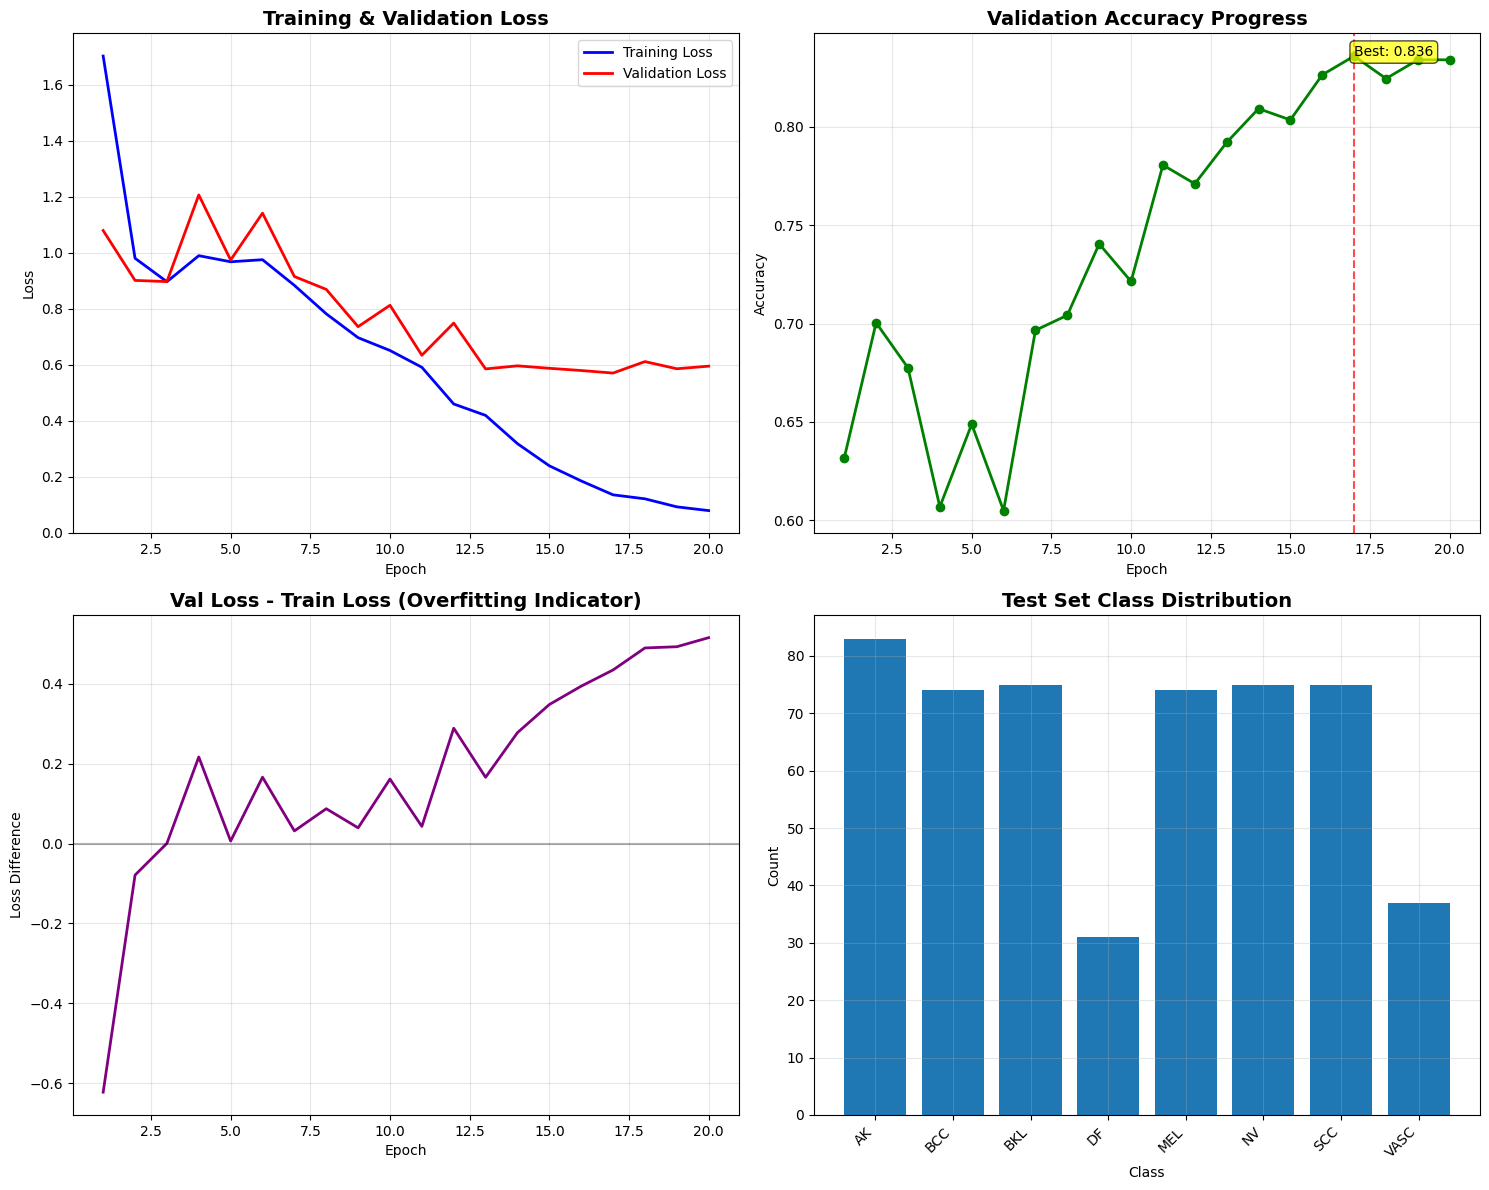


Overall testing results
Performance:
  - Test Accuracy: 0.8302 (83.02%)
  - Macro F1-Score: 0.8389
  - Weighted F1-Score: 0.8298

Confidence Analysis:
  - Average Confidence: 0.9359 ± 0.1224
  - High Confidence (>0.9): 80.9% of predictions
  - Medium Confidence (0.7-0.9): 11.8% of predictions
  - Low Confidence (<0.7): 7.3% of predictions

PER-CLASS PERFORMANCE ANALYSIS

Class                Precision  Recall     F1-Score   Support    Accuracy  
--------------------------------------------------------------------------------
AK                   0.812      0.783      0.798      83         0.783     
BCC                  0.904      0.892      0.898      74         0.892     
BKL                  0.849      0.827      0.838      75         0.827     
DF                   0.897      0.839      0.867      31         0.839     
MEL                  0.757      0.757      0.757      74         0.757     
NV                   0.846      0.880      0.863      75         0.880     
SCC         

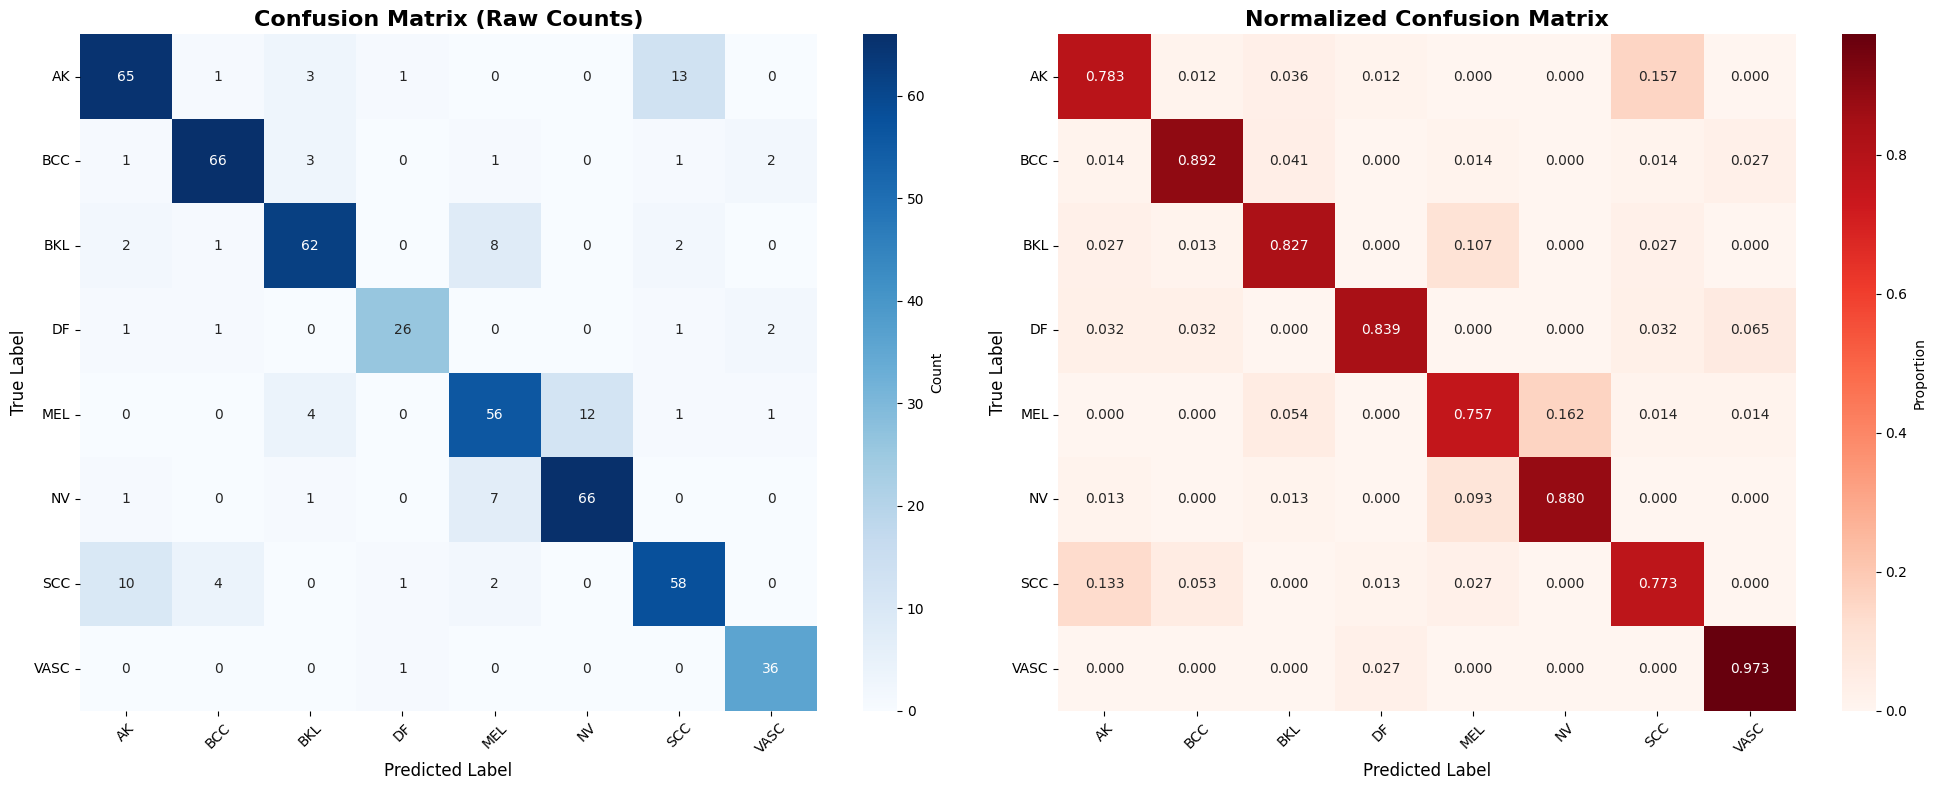


Confusion Matrix Analysis:
  - Most Confused Pair: MEL → NV (0.162)
  • AK most confused with: SCC (0.157)
  • BCC most confused with: BKL (0.041)
  • BKL most confused with: MEL (0.107)
  • DF most confused with: VASC (0.065)
  • MEL most confused with: NV (0.162)
  • NV most confused with: MEL (0.093)
  • SCC most confused with: AK (0.133)
  • VASC most confused with: DF (0.027)

COMPLETE ANALYSIS FINISHED!
Best validation: 83.6%
Test accuracy: 83.0%
Model saved as: fast_model.pth


In [16]:
# run model + training
model, model_analyzer, dataset_analyzer = main_ultra_fast_with_analysis()